### End-to-End Classification Problem


End-to-end analysis of a classification algorithm using `LogisticRegression`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc

### The Data

This data is originally from the IBM and contains information on a telecommunications company customer subscriptions. 

In [2]:
df = pd.read_csv('data/wa_churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype('float')

In [5]:
df = df.dropna()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Churn', 'customerID'], axis = 1), df['Churn'], random_state = 442,
                                                   stratify = df['Churn'])

#### Incorporate the categorical features. 

We will use column Transformers.

In [8]:
selector = make_column_selector(dtype_include=object)
transformer = make_column_transformer(
    (OneHotEncoder(drop='first'), selector),
    remainder = StandardScaler())

transformer

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001ED736E85F0>)])

#### Feature Extractor

In [10]:
extractor = ''
extractor = SelectFromModel(LogisticRegression(penalty='l1', random_state=42, solver='liblinear'))
extractor

SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear'))


#### Pipeline with Estimator

In [11]:

lgr_pipe = ''
pipe_1_acc = ''

lgr_pipe = Pipeline([
    ('transformer', transformer),
    ('selector', extractor),
    ('lgr', LogisticRegression(random_state=42, max_iter=1000))]
)

lgr_pipe.fit(X_train, y_train)
pipe_1_acc = lgr_pipe.score(X_test, y_test)
lgr_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001ED736E85F0>)])),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'))),
                ('lgr', LogisticRegression(max_iter=1000, random_state=42))])

#### Compare to Baseline

In [13]:
baseline_acc = y_test.value_counts(normalize=True).max()
if (pipe_1_acc > baseline_acc):
    print ('pipe_1 has better accuracy than base line')
    
else:
    print ('pipe_1 has worse accuracy than baseline')    

print ('pipe_1_acc: ', pipe_1_acc)
print ('baseline_acc: ', baseline_acc)


pipe_1 has better accuracy than base line
pipe_1_acc:  0.8185437997724687
baseline_acc:  0.7343572241183163


#### Confusion Matrix and ROC Curve

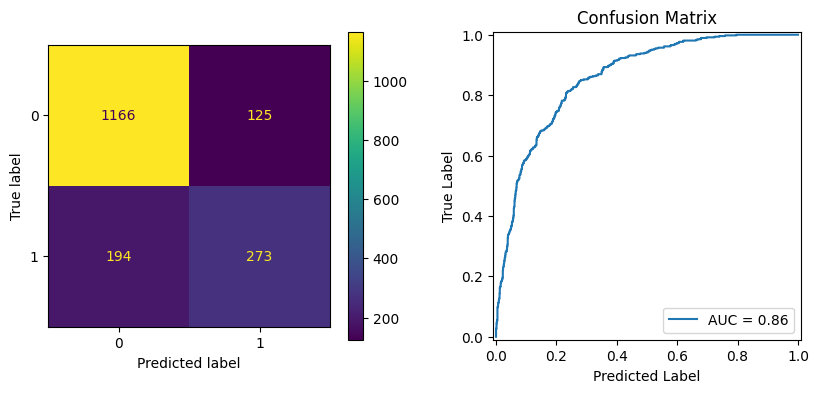

(np.int64(125), np.int64(194), np.float64(0.86))

In [14]:
from sklearn.metrics import auc as skl_auc
 
preds = lgr_pipe.predict(X_test)
conf_matrix = confusion_matrix(y_test, preds)
y_score = lgr_pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label='Yes')
roc_auc_value = skl_auc(fpr, tpr)

fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
auc = round(roc_auc_value, 2)
# 

fig, ax = plt.subplots(1,2, figsize=(10,4))
display1 = ConfusionMatrixDisplay(conf_matrix)
display1.plot(ax=ax[0])

display2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
display2.plot(ax=ax[1])

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()

fp, fn, auc

#### False Negatives.  
Use the `predict_proba` method to select the probabilities of the `No` class. 

In [15]:
no_probs = lgr_pipe.predict_proba(X_test)[:, 0]

no_probs[:5]

array([0.67123246, 0.61265653, 0.92315839, 0.97997049, 0.77108789])

#### Only target customers with high probability

In [16]:

high_prob_no = no_probs[no_probs > 0.8]
high_prob_no[:5]
print (type(no_probs))

<class 'numpy.ndarray'>



#### Number of Predictions


In [17]:

percent_of_test_data = ''
percent_of_no = ''

percent_of_test_data = len(high_prob_no)/y_test.size
percent_of_no = len(high_prob_no)/sum(y_test == 'No')

print(percent_of_test_data)
print(percent_of_no)

0.5079635949943118
0.691711851278079


#### Coefficients of the model. 


In [18]:

coef_df = ''
print (lgr_pipe.named_steps['lgr'].coef_[0])

feature_names = lgr_pipe.named_steps['transformer'].get_feature_names_out() 
selected_features = feature_names[ [int(i[1:]) for i in lgr_pipe.named_steps['selector'].get_feature_names_out()]]
clean_names = [i.split('__')[-1] for i in selected_features]
coef_df = pd.DataFrame({'feature': clean_names, 'coefs': lgr_pipe.named_steps['lgr'].coef_[0]})
coef_df['coefs'] = coef_df['coefs'].apply(abs)
coef_df = coef_df.sort_values(by = 'coefs', ascending = False)

coef_df.head()

[ 0.03292343  0.01520177 -0.09664826 -0.5729924   0.20425217  0.66687023
 -0.50180119 -0.15997495 -0.08494159 -0.74111105 -0.37740952  0.21115552
  0.21656207 -0.70017374 -1.316568    0.35846111 -0.09925031  0.17906835
 -0.12249805  0.07056396 -1.32153241  0.05918492  0.5816465 ]


,feature,coefs
20,tenure,1.321532
14,Contract_Two year,1.316568
9,TechSupport_No internet service,0.741111
13,Contract_One year,0.700174
5,InternetService_Fiber optic,0.666870
